In [4]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from astropy import units as u
from astropy.constants import M_earth, M_sun

from simulate_data import *

import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)

    - orbit_params = orbital parameters for each planet arranged as a list of lists:
        - period = period in days
        - ecc = eccentricity 
        - t_periastron = The epoch of a reference periastron passage in days.
        - omega = argument of periapsis in radans
        - Omega = longitude of ascending node  
        - incl = inclination in radians
        - m_planet = mass of planet in Earth masses 

In [5]:
# orbital parameters from https://www.princeton.edu/~willman/planetary_systems/Sol/
# BJD determined by converting values above using https://ssd.jpl.nasa.gov/tc.cgi#top

P_earth = 365.256
e_earth = 0.0167
Tper_earth= 2454115.5208333
omega_earth = np.radians(102.9)
Omega_earth = np.radians(0.0)
inclination_earth = np.radians(45.0)
m_earth = 1 #units m_earth



P_jup = 4327.631
e_jup = 0.0484
Tper_jup = 2455633.7215278
omega_jup = np.radians(274.3)
Omega_jup = np.radians(100.4)
inclination_jup = np.radians(1.304) + inclination_earth
m_jup = 317.83 #units m_earth


P_nep = 59758.97 
e_nep = 0.00859
Tper_nep = 2468662.5000000
omega_nep = np.radians(273.2)
Omega_nep = np.radians(131.784)
inclination_nep = np.radians(1.7700) + inclination_earth
m_nep = 17.204 #units m_earth5.9724



P_saturn = 10739.58 
e_saturn = 0.0539
Tper_saturn = 2452832.0625000
omega_saturn = np.radians(338.9)
Omega_saturn = np.radians(113.7)
inclination_saturn = np.radians(2.486) + inclination_earth
m_saturn = 95.159 #units m_earth




In [3]:
orbit_params_earth = [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
orbit_params_jup = [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, inclination_jup, m_jup]
orbit_params_saturn = [P_saturn, e_saturn, Tper_saturn, omega_saturn, Omega_saturn, inclination_saturn, m_saturn]
orbit_params_nep = [P_nep, e_nep, Tper_nep, omega_nep, Omega_nep, inclination_nep, m_nep]


orbit_params = orbit_params_jup

times_observed_astrometry = []
t_0 = int(Tper_earth)
for ii in range(t_0, t_0+1825):
    if ii % 130 == 0:
        times_observed_astrometry.append(ii-1)
        times_observed_astrometry.append(ii)
        times_observed_astrometry.append(ii+1)

n_planets = 1
t_dur_rv = 3650
n_obs_rv = 3000
sigma_rv = 0.01

sigma_theta = 0.1
sigma_rho = 0.005
plx = 0.1


simulate_and_plot(
    n_planets, 
    sigma_rv, 
    sigma_theta,
    sigma_rho,
    plx,
    orbit_params,
    ['#366537', '#db372b', '#00257c'],
    ['Jupiter'],
    t_dur_rv = t_dur_rv,
    n_obs_rv = n_obs_rv,
    times_observed_astrometry = times_observed_astrometry
    )



NameError: name 'omega_earth' is not defined

In [4]:
times, rv_results, theta_results, rho_results = simulate_data(
    n_planets, 
    sigma_rv, 
    sigma_theta,
    sigma_rho,
    plx,
    orbit_params,
    t_dur_rv = t_dur_rv,
    n_obs_rv = n_obs_rv,
    times_observed_astrometry = times_observed_astrometry
    )


[[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
     [rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
     [theta_orbit, theta_orbit_sum, theta_sim, theta_sim_sum],
     [rho_orbit, rho_orbit_sum, rho_sim, rho_sim_sum]]  = times, rv_results, theta_results, rho_results

(300,)
(300,)
(300,)


<ErrorbarContainer object of 3 artists>

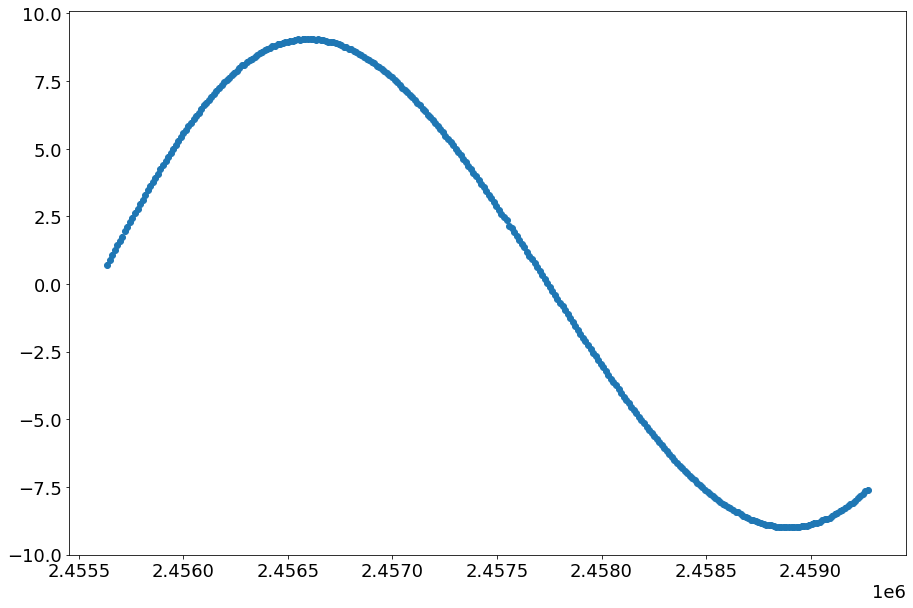

In [5]:
x_rv = times_observed_rv[1::10]
y_rv = rv_sim_sum[1::10]
y_rv_err = np.full(np.shape(y_rv), .1)

print(np.shape(x_rv))
print(np.shape(y_rv))
print(np.shape(y_rv_err))


plt.figure(figsize=[15,10])
plt.errorbar(x_rv,y_rv, yerr=y_rv_err, ls = '', marker = 'o')

We should have a decent understanding of the period of both Earth and Jupiter analogs from THE, so lets do an initial fit to get a sense of the planetary parameters using only the RVs for now.

In [6]:
import exoplanet as xo

periods = 3600
period_errs = 500
t0s = 2457500
t0_errs = 100
Ks = xo.estimate_semi_amplitude(periods, x_rv, y_rv, y_rv_err, t0s=t0s)
print(Ks, "m/s")

[8.6874217] m/s


Now that we have the data and an estimate of the initial values for the parameters, let’s start defining the probabilistic model in PyMC3 (take a look at A quick intro to PyMC3 for exoplaneteers if you’re new to PyMC3). First, we’ll define our priors on the parameters:

In [7]:
# Compute a reference time that will be used to normalize the trends model
x_rv_ref = 0.5 * (x_rv.min() + x_rv.max())
# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)

In [8]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # Gaussian priors based on transit data
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=1)
    P = pm.Bound(pm.Normal, lower=0)(
        "P",
        mu=np.array(periods),
        sd=np.array(period_errs),
        shape=1,
        testval=periods,
    )

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)(
        "logK", mu=np.log(Ks), sd=10.0, shape=1, testval=np.log(Ks)[0]
    )

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform(
        "ecc", shape=1, testval=0.1
    )
    omega = xo.distributions.Angle("omega", shape=1)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(y_rv_err)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=0.1, shape=1)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - x_rv_ref, 1)
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, vrad + bkg)

    # Define the RVs at the observed times
    rv_model = get_rv_model(x_rv)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(y_rv_err ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

Now, we can plot the initial model:

[-3.32247565 -3.27776816 -3.23286933 -3.18777999 -3.14250102 -3.09703329
 -3.05137769 -3.00553511 -2.95950648 -2.91329273 -2.86689478 -2.82031359
 -2.77355013 -2.72660537 -2.67948032 -2.63217597 -2.58469334 -2.53703347
 -2.4891974  -2.44118621 -2.39300095 -2.34464272 -2.29611263 -2.2474118
 -2.19854135 -2.14950243 -2.10029622 -2.05092389 -2.00138662 -1.95168564
 -1.90182216 -1.85179742 -1.80161268 -1.75126922 -1.70076831 -1.65011127
 -1.5992994  -1.54833406 -1.49721658 -1.44594834 -1.39453073 -1.34296514
 -1.291253   -1.23939574 -1.18739482 -1.13525171 -1.08296789 -1.03054488
 -0.97798419 -0.92528737 -0.87245598 -0.81949159 -0.7663958  -0.71317023
 -0.6598165  -0.60633627 -0.5527312  -0.49900299 -0.44515334 -0.39118398
 -0.33709665 -0.28289311 -0.22857515 -0.17414457 -0.11960319 -0.06495286
 -0.01019543  0.04466722  0.09963318  0.15470053  0.20986734  0.26513164
  0.32049145  0.37594478  0.4314896   0.48712387  0.54284553  0.59865249
  0.65454266  0.7105139   0.76656408  0.82269103  0.

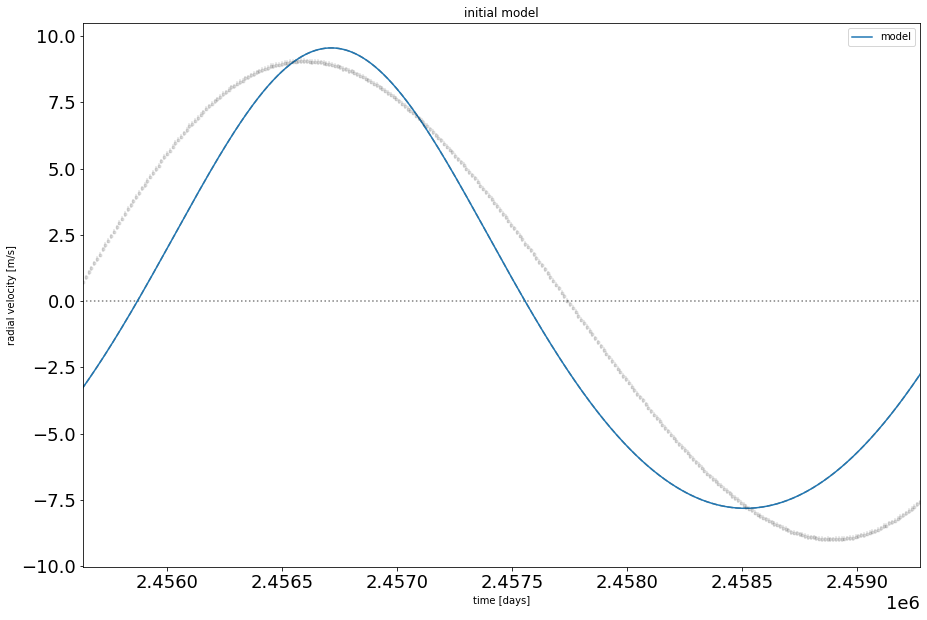

In [9]:
plt.figure(figsize=[15,10])

plt.errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.1)
with model:
    print(xo.eval_in_model(model.rv_model_pred))
    plt.plot(t, xo.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(model.bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(x_rv.min(), x_rv.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In [10]:
with model:
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [trend]


message: Optimization terminated successfully.
logp: -40383.11272903527 -> -36102.031419073886
optimizing logp for variables: [trend, logs, omega, ecc, logK, P, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -36102.031419073886 -> 418.25113940295404


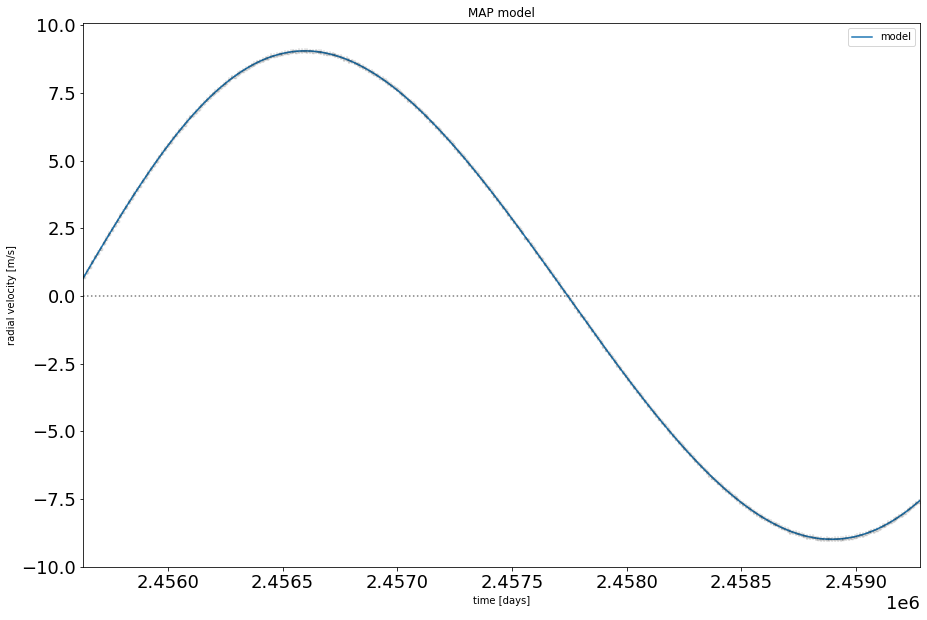

In [11]:
plt.figure(figsize=[15,10])
plt.errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.1)
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("MAP model")

In [12]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=4000,
        draws=4000,
        cores=2,
        chains=2,
        target_accept=0.95,
        init="adapt_full",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/Danielyahalomi/.local/lib/python3.6/site-packages/pymc3/step_methods/hmc/quadpotential.py:503: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 80 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [13]:
pm.summary(
    trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"]
)

/Users/Danielyahalomi/.local/lib/python3.6/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/Users/Danielyahalomi/.local/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
trend[0],0.001,0.011,-0.019,0.023,0.000,0.000,6770.0,3916.0,6772.0,5171.0,1.0
logs,-8.182,2.614,-13.031,-4.448,0.046,0.035,3198.0,2805.0,4256.0,3445.0,1.0
omega[0],-1.494,0.034,-1.557,-1.429,0.000,0.000,5863.0,5863.0,5929.0,5236.0,1.0
ecc[0],0.049,0.002,0.045,0.052,0.000,0.000,6610.0,6582.0,6576.0,4202.0,1.0
t0[0],2457740.528,1.497,2457737.737,2457743.393,0.018,0.013,6968.0,6887.0,6946.0,5435.0,1.0
logK[0],2.200,0.001,2.198,2.202,0.000,0.000,9627.0,9627.0,9598.0,5892.0,1.0
P[0],4327.058,8.658,4311.282,4343.599,0.110,0.078,6139.0,6136.0,6140.0,4444.0,1.0


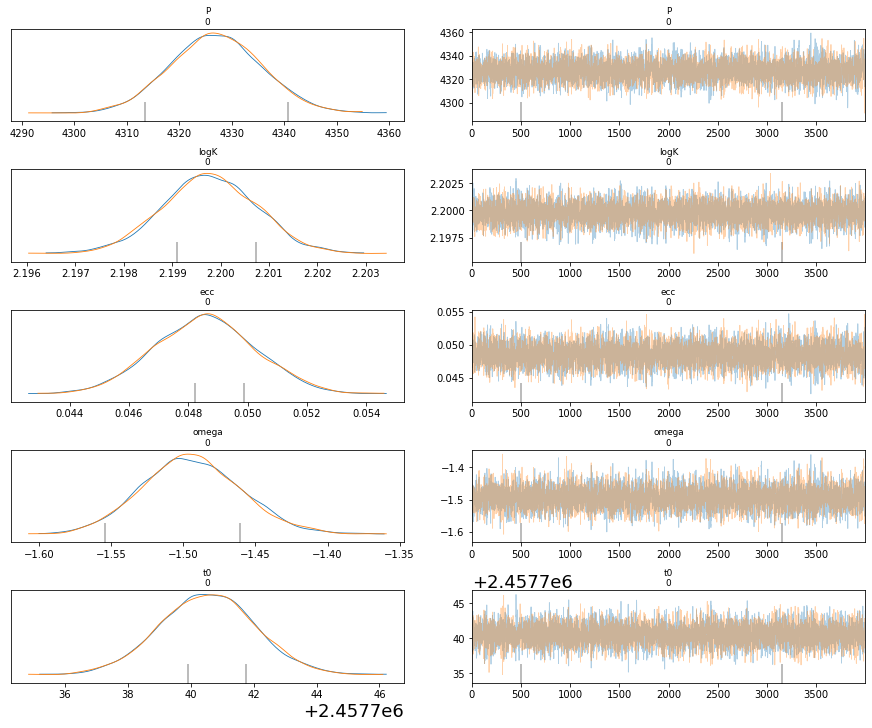

In [14]:
import arviz as az

with model:
    az.plot_trace(trace, var_names=["P", "logK", "ecc", "omega", "t0"])

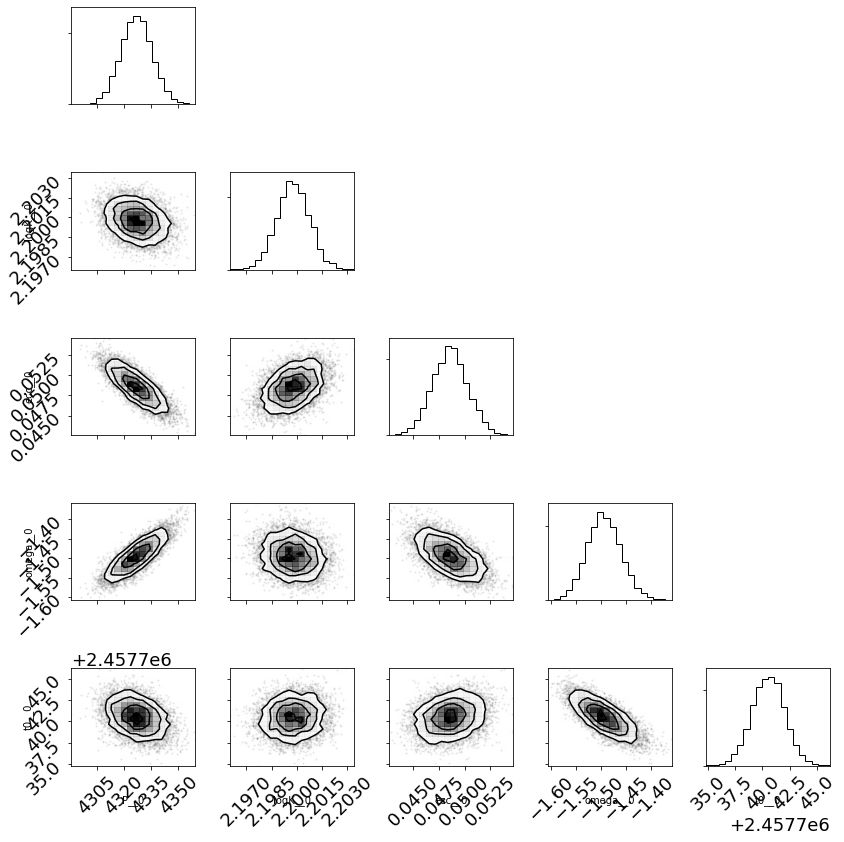

In [15]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc", "omega", "t0"])
_ = corner.corner(samples)
plt.tight_layout()

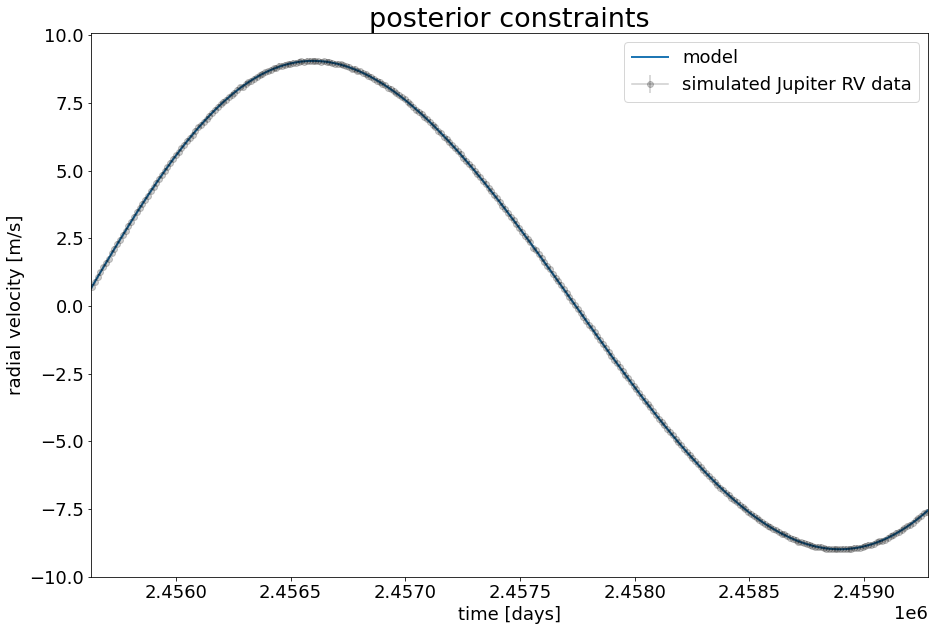

In [16]:
plt.figure(figsize = [15,10])
plt.errorbar(x_rv, y_rv, yerr=y_rv_err, color="k", marker='o', alpha = 0.2, label = 'simulated Jupiter RV data')

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model", linewidth = 2)
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=18)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]", fontsize=18)
plt.ylabel("radial velocity [m/s]", fontsize=18)
_ = plt.title("posterior constraints", fontsize=27)

In [17]:
P_pred = np.percentile(trace["P"], [50])[0]
t0_pred = np.percentile(trace["t0"], [50])[0]
logK_pred = np.percentile(trace["logK"], [50])[0]
omega_pred = np.percentile(trace["omega"], [50])[0]
ecc_pred = np.percentile(trace["ecc"], [50])[0]



In [18]:
print(P_pred)
print(t0_pred)
print(logK_pred)
print(omega_pred)
print(ecc_pred)


4326.998833263902
2457740.5366929686
2.199764406344248
-1.4953308838938955
0.04855549084909528


In [19]:
x_astrometry = times_observed_astrometry

theta_data = theta_sim_sum
theta_err = np.full(np.shape(theta_data), .01)

rho_data = rho_sim_sum
rho_err = np.full(np.shape(rho_data), .01)


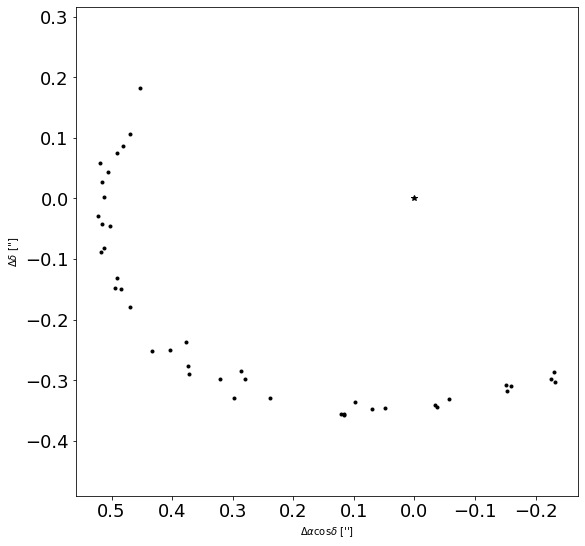

In [20]:
# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(9,9))

xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")

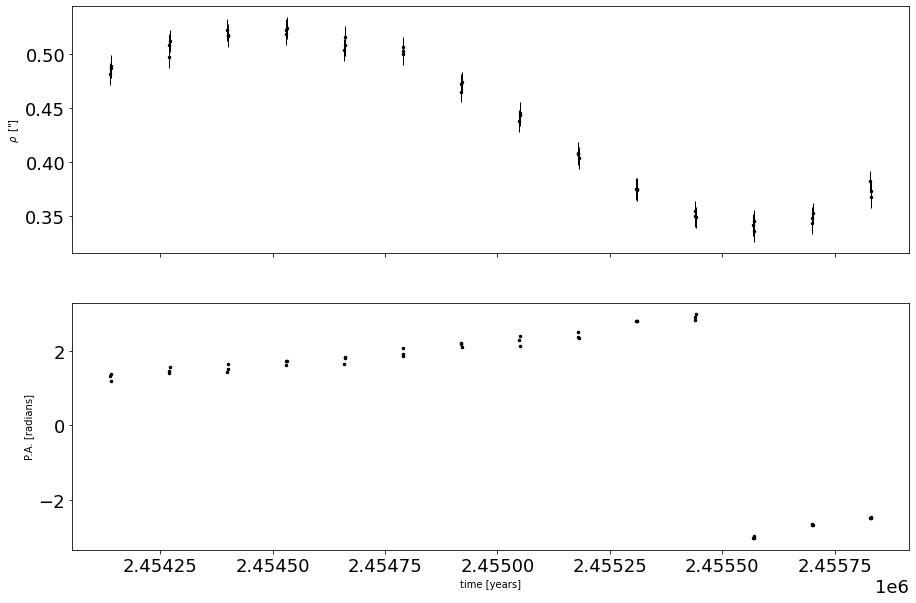

In [21]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize = [15,10])
ax[0].errorbar(x_astrometry, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(x_astrometry, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [years]")

As a first pass, let's try to fit the astrometry using the RV results

assume distance = 10pc, or parallax of 0.1 arcseconds

In [22]:
parallax = plx

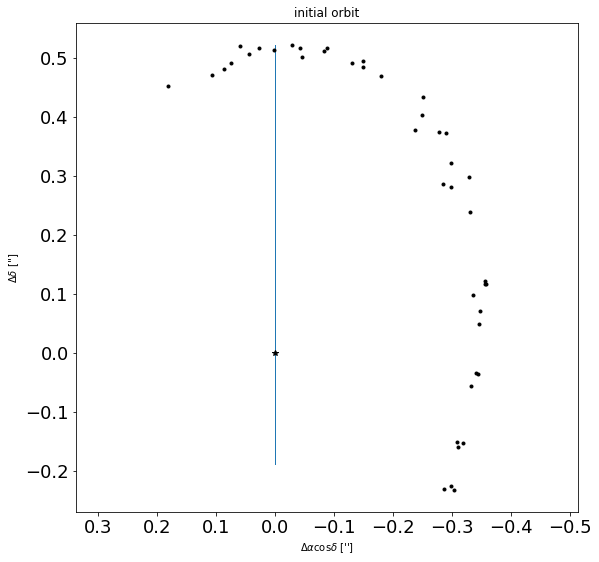

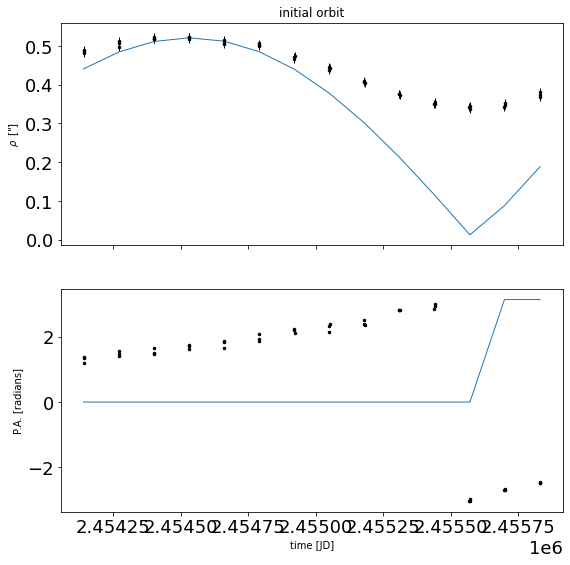

In [23]:
import theano
from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    t0=t0_pred, period=P_pred, ecc=ecc_pred, omega=omega_pred, K=np.e**logK_pred
)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
rho, theta = theano.function([], orbit.get_relative_angles(x_astrometry, parallax))()

# Plot the orbit
fig, ax = plt.subplots(nrows=1, figsize=(9, 9))

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
ax.plot(rho_data * np.cos(theta_data), rho_data * np.sin(theta_data), ".k")


ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(9, 9))
ax[0].errorbar(x_astrometry, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(x_astrometry, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit")

ax[1].errorbar(x_astrometry, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(x_astrometry, theta, color="C0", lw=1)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [JD]")

Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.


In [45]:
from exoplanet.distributions import Angle
yr = 365.25

# for predicted orbits
t_fine = np.linspace(np.array(x_astrometry).min() - 500, np.array(x_astrometry).max() + 500, num=1000)


def get_model(parallax=None):
    with pm.Model() as model:

        print(parallax)
        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)(
                "m_plx", mu=parallax*1000, sd=1000, testval=parallax*1000
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)
        
        
        a_ang = pm.Uniform("a_ang", 0.1, 1)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 10 years,
        # so we'll set a broad prior on logP
        logP = pm.Normal(
            "logP", mu=np.log(10 * yr), sd=5.0, testval=np.log(10 * yr)
        )
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        omega0 = omega_pred

        #p = Angle("p", testval=0.5 * (Omega0 + omega0))
        #m = Angle("m", testval=0.5 * (Omega0 - omega0))
        omega_mod = pm.Uniform("omega", lower = 0, upper = np.pi, testval = omega_pred)
        Omega_mod = pm.Uniform("Omega", lower = 0, upper = np.pi)
        #omega = pm.Deterministic("omega", p - m)
        #Omega = pm.Deterministic("Omega", p + m)

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = Angle("phase")
        tperi = pm.Deterministic("tperi", t0_pred + P_pred * phase / (2 * np.pi))

        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform(
            "cos_incl", lower=-1, upper=1)
        
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=ecc_pred)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun,
            t_periastron=tperi,
            period=P,
            incl=incl,
            ecc=ecc,
            omega=omega_mod,
            Omega=Omega_mod,
        )
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)

        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(x_astrometry, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal(
            "log_rho_s", mu=np.log(np.median(rho_err)), sd=0.05
        )
        log_theta_s = pm.Normal(
            "log_theta_s", mu=np.log(np.median(theta_err)), sd=5.0
        )
        rho_tot_err = tt.sqrt(rho_err ** 2 + tt.exp(2 * log_rho_s))
        theta_tot_err = tt.sqrt(theta_err ** 2 + tt.exp(2 * log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        #print(len(rho_model), len(rho_tot_err), len(rho_data))
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(
            tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data)
        )
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = xo.optimize(map_soln, vars=[phase])
        map_soln = xo.optimize(map_soln, vars=[omega_mod, Omega_mod, ecc])
        map_soln = xo.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = xo.optimize(map_soln)

    return model, map_soln


model, map_soln = get_model(parallax = parallax)


0.1


optimizing logp for variables: [log_theta_s, log_rho_s]


message: Desired error not necessarily achieved due to precision loss.
logp: nan -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


optimizing logp for variables: [phase]


message: Desired error not necessarily achieved due to precision loss.
logp: nan -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


optimizing logp for variables: [ecc, Omega, omega]


message: Desired error not necessarily achieved due to precision loss.
logp: nan -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


optimizing logp for variables: [phase, a_ang, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: nan -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]


message: Desired error not necessarily achieved due to precision loss.
logp: nan -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


In [36]:
print(map_soln['rho_save'])

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

/Users/Danielyahalomi/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/Danielyahalomi/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


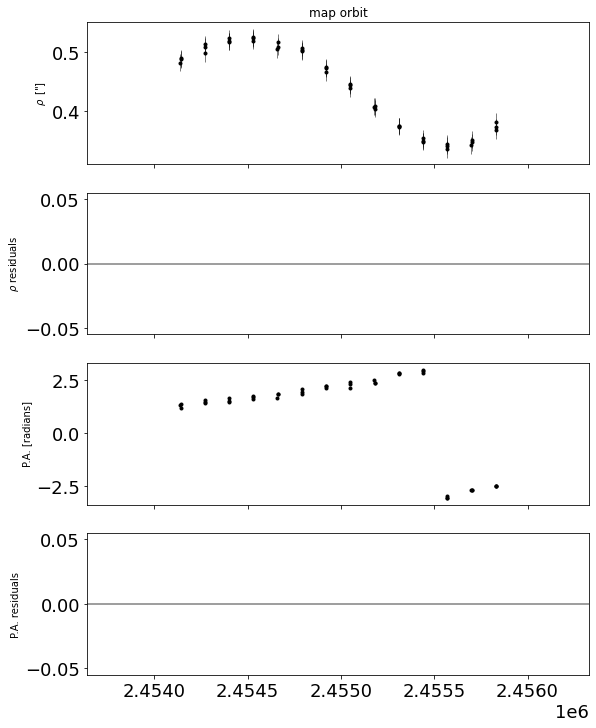

In [25]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(9, 12))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err ** 2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(x_astrometry, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    x_astrometry, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw
)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(x_astrometry, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    x_astrometry, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")